In [1]:
# Import packages 
import os
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.colors as colors
import matplotlib.gridspec as gsp

from scipy.io import FortranFile

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import importlib
import glob
import copy

import Plots as Po

importlib.reload(Po)

#sys.path.append('../Plotting/')
#   Now you can imprt modules in ../Plotting
#import xyp_plot as xyp
#import ana as a


/project/amp/juliob/MiniConda/envs/adf_v0.07/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'Plots' from '/project/amp/juliob/myPythonTools/TopoAna/Plots.py'>

In [2]:
TopoRoot = '/project/amp/juliob/Topo-generate-devel/Topo/Topo.git/'
Case = 'fv_0.9x1.25_Sco100_fix'
cgrid= 'fv_0.9x1.25'
Gridkey='yx'

In [3]:
foo=glob.glob( TopoRoot +'/cases/'+ Case + '/output/'+cgrid+'*.nc')
FileN = foo[-1]
print(FileN)
dCAM=xr.open_dataset( FileN )
print( list(dCAM.variables) )
print(np.shape(dCAM['lat']))
lonc=dCAM['lon'].values
latc=dCAM['lat'].values
angl=dCAM['ANGLL'].values
hwdt=dCAM['HWDTH'].values
clng=dCAM['CLNGT'].values
mxd=dCAM['MXDIS'].values
sgh=dCAM['SGH'].values


/project/amp/juliob/Topo-generate-devel/Topo/Topo.git//cases/fv_0.9x1.25_Sco100_fix/output/fv_0.9x1.25_gmted2010_modis_bedmachine_nc3000_Laplace0100_20230412.nc
['PHIS', 'LANDFRAC', 'SGH', 'SGH30', 'LANDM_COSLAT', 'lat', 'lon', 'TERR_UF', 'SGH_UF', 'GBXAR', 'MXDIS', 'RISEQ', 'FALLQ', 'MXVRX', 'MXVRY', 'ANGLL', 'ANGLX', 'ANISO', 'ANIXY', 'HWDTH', 'WGHTS', 'CLNGT', 'CWGHT', 'COUNT']
(192,)


In [4]:
foo=glob.glob( TopoRoot +'/cases/'+ Case + '/output/topo*.nc')
FileN = foo[-1]
print(FileN)
topo=xr.open_dataset( FileN )
print(list(topo.variables))
print(topo.attrs)
raw=topo['terr_dev']+topo['terr_sm']
Loo = np.size(raw)
nc=int(np.sqrt( Loo/6 ))
print(int(nc))
raw=np.reshape( raw.values , (6,nc,nc) )
dev=np.reshape( topo['terr_dev'].values , (6,nc,nc) )
smoo=np.reshape( topo['terr_sm'].values , (6,nc,nc) )
tlats=np.reshape( topo['lat'].values , (6,nc,nc) )
tlons=np.reshape( topo['lon'].values , (6,nc,nc) )


/project/amp/juliob/Topo-generate-devel/Topo/Topo.git//cases/fv_0.9x1.25_Sco100_fix/output/topo_smooth_gmted2010_modis_bedmachine_nc3000_Co060.nc
['terr_sm', 'terr_dev', 'landfrac', 'lat', 'lon']
{'data_summary': 'Smoothed topo data for quicker generation of topography data', 'creation_date': '20230412', 'cesm_contact': 'Peter Hjort Lauritzen and Julio Bacmeister', 'data_source': 'https://github.com/NCAR/Topo.git', 'data_script': './cube_to_target --grid_descriptor_file /project/amp/juliob/Topo-generate-devel/Topo/inputdata/grid-descriptor-file/fv_0.9x1.25.nc --intermediate_cs_name /project/amp/juliob/Topo-generate-devel/Topo/inputdata/cubed-sphere-topo/gmted2010_modis_bedmachine-ncube3000-220518.nc --output_grid fv_0.9x1.25 --smoothing_scale 100.00000000000000 --fine_radius 0 --name_email_of_creator juliob@ucar.edu --output_data_directory output/ --development_diags', 'data_reference': 'Lauritzen, P. H. et al.: NCAR global model topography generation software for unstructured grids, G

In [5]:

wlon,elon=-77.,-57.
slat,nlat=-58,-45


if (elon<0.):
    elon=elon+360.
if (wlon<0.):
    wlon=wlon+360.

lonrange=np.asarray([wlon,elon] ) #-2
latrange=np.asarray([slat,nlat]) #-4

#Which panel will you be in?
ip=4

In [6]:
if (Gridkey=='c'):
    zoo=np.where( ( (lonc<=lonrange[1])&(lonc>lonrange[0]) )&( (latc<=latrange[1])&(latc>latrange[0]) ) )
    print(len(zoo[0]))
    iroo=zoo[0]
elif (Gridkey=='yx'):
    zoox=np.where( ( (lonc<=lonrange[1])&(lonc>lonrange[0]) ) )
    zooy=np.where( ( (latc<=latrange[1])&(latc>latrange[0]) ) )
    print(len(zoox[0]),len(zooy[0]))
    iroox=zoox[0]
    irooy=zooy[0]

print(np.shape(angl))

16 14
(16, 192, 288)


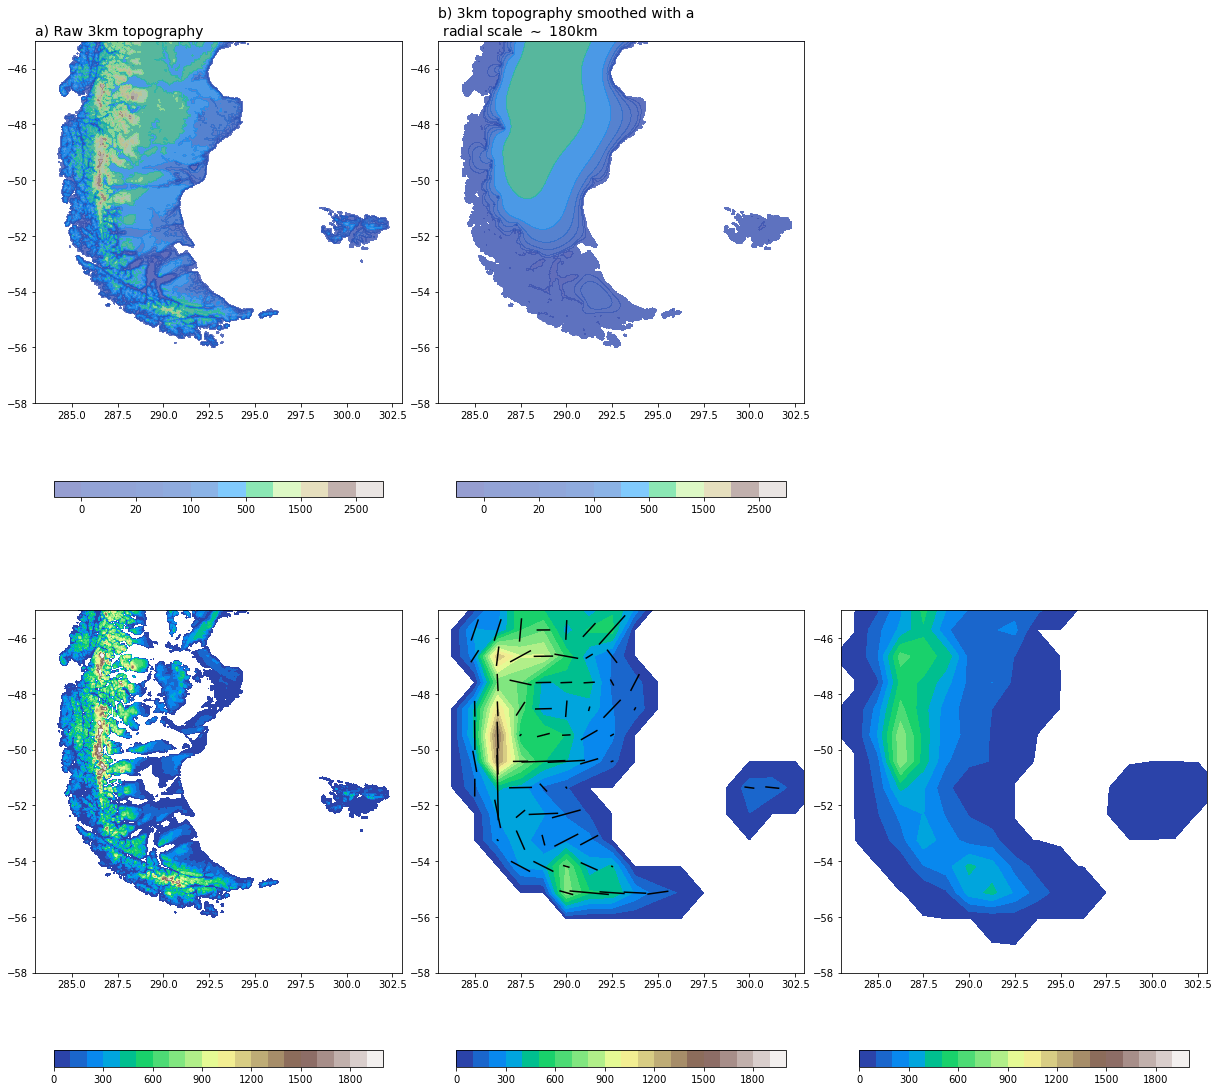

In [7]:
terrlev=[-100,0,10,20,50,100,200,500,1000,1500,2000,2500,3000 ] #,3500,4000]
devlev=np.linspace(0,2000,num=21)
cmap=plt.cm.terrain

"""
fig,ax = plt.subplots(2,3,figsize=(21,20) ,squeeze=False ) # , sharex=True)

"""
fig = plt.figure(figsize=(21,20)  ) # , sharex=True)
gs = gsp.GridSpec( 2, 3, figure=fig ,wspace=0.1, hspace=0.1 )
    
j,i=0,0
ax=fig.add_subplot(gs[j,i])
u=ax.contourf( tlons[ip,:,:],tlats[ip,:,:],raw[ip,:,:], levels=terrlev, cmap='terrain',alpha=.5) #,
ax.set_xlim(lonrange)
ax.set_ylim(latrange)
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)
ax.set_title(loc='left',label='a) Raw 3km topography' , fontsize=14)


j,i=0,1
#plt.contourf( tlons[ip,:,:],tlats[ip,:,:],mxdis[ip,:,:], levels=np.linspace(-100,500.,num=21), cmap='terrain' ,alpha=.5) #,
ax=fig.add_subplot(gs[j,i])
u=ax.contourf( tlons[ip,:,:],tlats[ip,:,:],smoo[ip,:,:], levels=terrlev, cmap='terrain',alpha=.5) #,
ax.set_xlim(lonrange)
ax.set_ylim(latrange)
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)
ax.set_title(loc='left',label='b) 3km topography smoothed with a \n radial scale $\sim$ 180km ' , fontsize=14)

j,i=1,0
#plt.contourf( tlons[ip,:,:],tlats[ip,:,:],mxdis[ip,:,:], levels=np.linspace(-100,500.,num=21), cmap='terrain' ,alpha=.5) #,
ax=fig.add_subplot(gs[j,i])
u=ax.contourf( tlons[ip,:,:],tlats[ip,:,:],dev[ip,:,:], levels=devlev, cmap='terrain',alpha=1) #,
ax.set_xlim(lonrange)
ax.set_ylim(latrange)
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)

j,i=1,1
ax=fig.add_subplot(gs[j,i])
if (Gridkey=='c'):
    u=ax.tricontourf(lonc,latc,mxd[0,:], levels=devlev, cmap='terrain',alpha=1)
    for ir in iroo:
        lat0,lon0 = latc[ir],lonc[ir]
        lat1,lon1,lat2,lon2 = Po.CAMridgelet(lat=lat0 ,lon=lon0 , angll=angl[0,ir], clngt=clng[0,ir] )
        plt.plot( [lon1,lon2] , [lat1,lat2], color='black' )
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)
    
    
if (Gridkey=='yx'):
    u=ax.contourf(lonc,latc,mxd[0,:,:]-1, levels=devlev, cmap='terrain',alpha=1)
    for iry in irooy:
        for irx in iroox:
            lat0,lon0 = latc[iry],lonc[irx]
            lat1,lon1,lat2,lon2 = Po.CAMridgelet(lat=lat0 ,lon=lon0 , angll=angl[0,iry,irx], clngt=clng[0,iry,irx] )
            if(mxd[0,iry,irx]>100.):
                ax.plot( [lon1,lon2] , [lat1,lat2], color='black' )
    
ax.set_xlim(lonrange)
ax.set_ylim(latrange)

"""
j,i=1,2
#plt.contourf( tlons[ip,:,:],tlats[ip,:,:],mxdis[ip,:,:], levels=np.linspace(-100,500.,num=21), cmap='terrain' ,alpha=.5) #,
ax=fig.add_subplot(gs[j,i])
u=ax.contourf( tlons[ip,:,:],tlats[ip,:,:],wedgo[ip,:,:], levels=devlev, cmap='terrain',alpha=1) #,
ax.set_xlim(lonrange)
ax.set_ylim(latrange)
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)
"""

j,i=1,2
ax=fig.add_subplot(gs[j,i])
if (Gridkey=='yx'):
    u=ax.contourf(lonc,latc,sgh[:,:]-1, levels=devlev, cmap='terrain',alpha=1)
ax.set_xlim(lonrange)
ax.set_ylim(latrange)
plt.colorbar(u,ax=ax,location='bottom',shrink=.9)


#ax1 = fig.add_subplot(3, 4, ipoo , projection=ccrs.PlateCarree(central_longitude=0))
#cf = ax1.contourf(xlon, xlat, gutnx[L,:,:],  levels=clevs, cmap=cmap  , transform=ccrs.PlateCarree())